In [2]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [3]:
data = h5py.File("../../data/glove-25-angular.hdf5", "r")

In [49]:
df = pd.read_csv("PQ_filter_eip_vs_tip_maha_m8_k256_100k.txt", header=None, names=["depth", "range_idx", "eip", "tip"])
last = -1
id = -1
newCol = []
for idx, val in enumerate(df["range_idx"][:]):
    if (last != 0 and val == 0): id += 1
    last = val
    newCol.append(id*100)

df["query_id"] = newCol

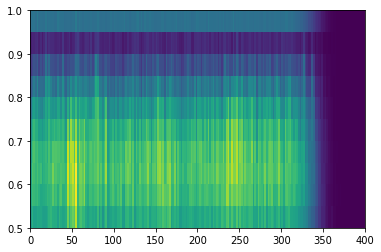

In [50]:
t = plt.hist2d(df["range_idx"], df["tip"], bins= [200, 10], density=True, range = [[0,400], [0.5, 1]])

In [51]:
df = pd.read_csv("PQ_filter_eip_vs_tip_euclidian_m8_k256_100k.txt", header=None, names=["depth", "range_idx", "eip", "tip"])
last = -1
id = -1
newCol = []
for idx, val in enumerate(df["range_idx"][:]):
    if (last != 0 and val == 0): id += 1
    last = val
    newCol.append(id*100)

df["query_id"] = newCol

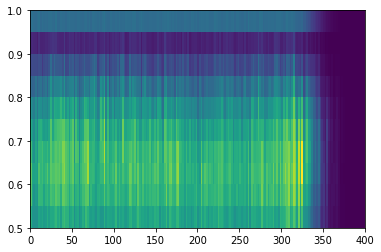

In [52]:
t = plt.hist2d(df["range_idx"], df["tip"], bins= [200, 10], density=True, range = [[0,400], [0.5, 1]])

In [53]:
df = pd.read_csv("PQ_filter_eip_vs_tip_euclidian_m8_k256_100k_highrecall.txt", header=None, names=["depth", "range_idx", "eip", "tip"])
last = -1
id = -1
newCol = []
for idx, val in enumerate(df["range_idx"][:]):
    if (last != 0 and val == 0): id += 1
    last = val
    newCol.append(id*100)

df["query_id"] = newCol

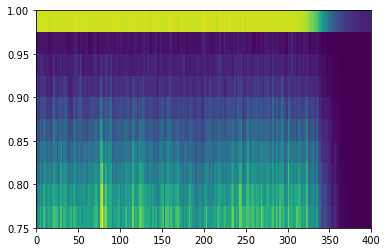

In [56]:
t = plt.hist2d(df["range_idx"], df["tip"], bins= [200, 10], density=True, range = [[0,400], [0.75, 1]])

In [64]:
res = []
for title, group in df.groupby("range_idx"):
    res.append(np.mean(group["tip"].nlargest(4000)))
    
    

Text(0, 0.5, 'mean of top 4000 true inner product')

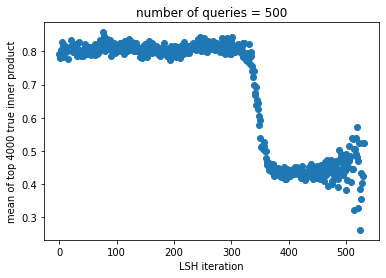

In [67]:
#this takes mean, we should look at how many of the true NN are in each LSH iteration
plt.scatter([i for i in range(len(res))], res)
plt.title("number of queries = 500")
plt.xlabel("LSH iteration")
plt.ylabel("mean of top 4000 true inner product")

In [93]:
from collections import defaultdict

def def_value():
    return [0,0]

res = defaultdict(def_value)
for titel, q_id in df.groupby("query_id"):
    top20 = set(q_id["tip"].nlargest(20))
    for titel1, r_id in q_id.groupby("range_idx"):
        top20inRange = len(set(r_id["tip"]).intersection(top20))
        res[titel1] = [res[titel1][0] + top20inRange, res[titel1][1]+ len(r_id["tip"])]
        #break
    #break
       
     

Text(0, 0.5, 'fraction of True NN')

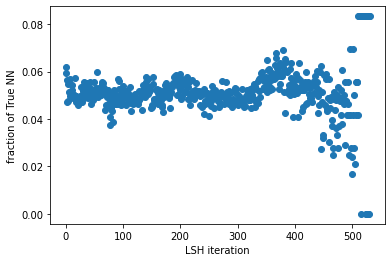

In [97]:
plt.scatter(res.keys(), [x/y for x,y in res.values()])
plt.xlabel("LSH iteration")
plt.ylabel("fraction of True NN")

Text(0, 0.5, 'count of top 20')

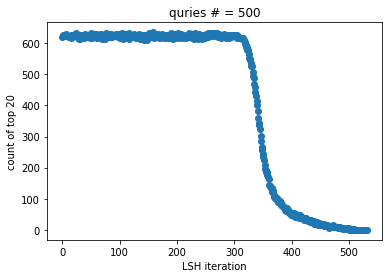

In [98]:
plt.scatter(res.keys(), [x for x,y in res.values()])
plt.title("quries # = 500")
plt.xlabel("LSH iteration")
plt.ylabel("count of top 20")

In [11]:
df = pd.read_csv("../../data/static_correctness_m4k32_50k.csv", header=None, names=["id", "how many correct"])
np.sum(df["how many correct"])

499998

In [12]:
df = pd.read_csv("../../data/dynamic_correctness_m4k32_50k.csv", header=None, names=["id", "how many correct"])
np.sum(df["how many correct"])


499992

In [7]:
data.keys()

<KeysViewHDF5 ['estimated_inner', 'threshholds', 'threshholds_boot_k', 'true_inner']>

In [38]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
data = h5py.File("../../data/glove-100-angular_mahalanobis_16_no_perm.hdf5", "r")
estimated_IP    = data['estimated_inner'][:].reshape(-1,1)
true_IP         = data['true_inner'][:].reshape(-1,1)



In [39]:
error = estimated_IP - true_IP
print(error.shape)

(118351400, 1)


In [40]:
mask = true_IP > -2

EIP = estimated_IP[mask]
TIP = true_IP[mask]
IP_error = error[mask]

EIP = EIP.reshape(-1,1)
TIP = TIP.reshape(-1,1)
IP_error = IP_error.reshape(-1,1)

sample_mask = np.random.randint(len(EIP), size= 5_000_000)

EIP = EIP[sample_mask]
TIP = TIP[sample_mask]
IP_error = IP_error[sample_mask]
print(EIP.shape, TIP.shape, IP_error.shape)

(5000000, 1) (5000000, 1) (5000000, 1)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(TIP, IP_error, test_size=0.1, random_state=42)

In [42]:
np.sum(TIP < -0.7)

33

In [33]:
model = Pipeline(
        steps=[ ('many', PolynomialFeatures()),
                ('skrrt', LinearRegression())]
)

param_grid_hue = {
        "many__degree" : [1],
        "many__interaction_only" : [True , False]
}
gsc = GridSearchCV (model , param_grid = param_grid_hue , scoring ='neg_mean_squared_error')
gsc.fit(X_train, y_train)
#model.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('many', PolynomialFeatures()),
                                       ('skrrt', LinearRegression())]),
             param_grid={'many__degree': [1],
                         'many__interaction_only': [True, False]},
             scoring='neg_mean_squared_error')

In [46]:
gsc.best_params_
hue = LinearRegression()
hue.fit(X_train, y_train)
hue.intercept_

array([0.02679608], dtype=float32)

In [45]:
for val in gsc.predict([[x] for x in np.linspace(0,1,11)]):
    print(val)

[0.02679608]
[0.00403478]
[-0.01872651]
[-0.04148781]
[-0.0642491]
[-0.0870104]
[-0.1097717]
[-0.13253299]
[-0.15529429]
[-0.17805558]
[-0.20081688]


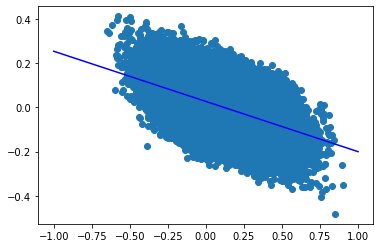

In [36]:
x = [[x]for x in np.linspace(-1,1,100)]
y = gsc.predict(x)
amount = 100_000
bid = 0
plt.scatter(X_train[bid*amount:(bid+1)*amount], y_train[bid*amount:(bid+1)*amount])
#plt.plot(x, x, c = "red")
plt.plot(x,y, "b-")